# Chapter 16: RNN과 어텐션을 사용한 자연어 처리
* 자연어 문제를 위해 사용하는 방법 : 순환신경망 (RNN)

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

## 16.1 Char-RNN을 사용해 셰익스피어 문체 생성하기 

In [2]:
# 셰익스피어 작품 다운로드

shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1130496/1115394 [==============================] - 0s 0us/step


In [3]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [4]:
# 모든 글자를 정수로 인코딩하기
# 텍스트에서 사용되는 모든 글자를 찾아 각기 다른 글자 ID에 매핑
# char_level=True : 글자 수준 인코딩, 기본적으로 텍스트를 소문자로 바꿈

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [5]:
# 문장 -> 글자 ID로 인코딩

tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [6]:
#글자 ID -> 문장으로 디코딩

tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [7]:
max_id = len(tokenizer.word_index) # 고유한 문자 개수
dataset_size = tokenizer.document_count # 전체 문자 개수

In [8]:
# shakespeare_text를 글자 id로 인코딩 (1~39대시 0~38 값을 얻기 위해 -1)

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

### 16.1.2 순차 데이터셋을 나누는 방법

훈련, 검증, 테스트 세트가 중복되지 않도록 만드는 것이 중요 <br>
두 세트 사이에 문장이 걸치지 않고 완전히 분리될 수 있도록 세트 사이에 간격을 두는 것이 좋음 <br>

* 시계열 데이터 <br>
시간에 따라 나누는 것이 안전 <br>
RNN이 과거(훈련세트)에서 학습하는 패턴이 미래에도 등장한다고 가정 <br>
많은 경우 시계열에서 이 가정이 타당하지만 그렇지 않은 경우도 있음 <br>

In [9]:
# 텍스트의 처음 90%를 훈련 세트로 활용

train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### 16.1.3 순차 데이터를 위도 여러 개로 자르기

window() : 시퀀스 하나를 작은 많은 텍스트 윈도로 변환 <br>
데이터셋의 각 샘플 = 전체 텍스트에서 매우 짧은 문자열 <br>

예시) 0 1 2 3 4 5 6 7 8 9 <br>
=> 0 1 2 3 / 1 2 3 4 / 2 3 4 5 / 3 4 5 6 / 4 5 6 7 / 5 6 7 8 <br>

window() : 중첩 데이터셋 -> flat_map()을 통해서 플랫 데이터셋으로 만들기 <br>
예시) {{1, 2}, {3, 4, 5, 6}} => {1,2,3,4,5,6}

In [10]:
n_steps = 100
window_length = n_steps + 1 # 타깃 = 한 글자 앞선 입력
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [11]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

In [14]:
# 입력 (첫 100글자), 타깃 (마지막 100글자) 분리

dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [15]:
# 원-핫 벡터로 인코딩
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [16]:
# 가져오기(Prefetching)
# 전처리와 훈련 스텝의 모델 실행을 오버랩
# 모델이 s스텝 훈련을 실행하는 동안 입력 파이프라인은 s+1스텝의 데이터를 읽음 => 시간 단축

dataset = dataset.prefetch(1)

* window 크기 : 11,  배치크기 : 3 <br>
![image.png](attachment:image.png)


### 16.1.4 Char-RNN 모델 만들고 훈련하기

목표 : 이전 글자 100개를 기반으로 다음 글자 예측하기 <br>

In [18]:
# GRU 층 2개 > 출력층 (39 : 텍스트에 있는 고유한 글자 수)
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
    160/Unknown - 47s 259ms/step - loss: 2.7765

KeyboardInterrupt: ignored

### 16.1.5 Char-RNN 모델 사용하기

In [19]:
# 전처리
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [20]:
# 예측
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

### 16.1.6 가짜 셰익스피어 텍스트를 생성하기

* Char-RNN 모델을 사용해 새로운 텍스트를 생성하는 방법 <br>
초기 텍스트 주입 > 모델이 다음 글자 예측 > 예측한 글자를 텍스트 끝에 추가 > 텍스트를 다시 모델에 전달 > 다음 글자 예측 <br>
* 단점) 같은 단어가 반복됨 <br>
* 해결) tf.random.categoricla() 함수 : 모델이 추정한 확률을 기반으로 다음 글자 무작위 선택 <br>
<br>

* 상태가 없는 RNN : 각 반복에서 무작위하게 택한 텍스트의 일부분으로 학습
* 상태가 있는 RNN : 훈련 반복 사이의 중지된 곳에서 이어서 상태 반영 <br>
→ GPU 층의 stateful=True로 지정하고 에포크 끝마다 상태를 재설정하면 됨

In [21]:
# 다음 글자 예측 & 입력 텍스트에 추가 

def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [22]:
# next_char() 함수 반복 호출

def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [23]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the he the the cout the your the the the the cous a


In [24]:
print(complete_text("t", temperature=1))

t,che' taedi'to..
whey, yoy theof ocucise yo whats 


In [25]:
print(complete_text("t", temperature=2))

t, liecqt;ruthabzeni:ih chaa? itpgul arkh,rgib 
kok


## 16.2 감성 분석

- IMDb : 자연어 처리 데이터셋 <br>
→ 영어로 쓰인 영화 리뷰 50,000개로 구성 (25,000 훈련, 25,000 테스트) <br>
→ 타깃 : 긍정적 리뷰 (1) / 부정적 리뷰 (0) <br>
<br>

- X_train : 리뷰들의 리스트 (넘파이 정수 배열)<br>
→ 각 정수는 하나의 단어를 나타냄 (낮은 정수가 자주 등장하는 단어)<br>
→ 0 : 패딩 토큰, 1 : SOS 토큰, 2 : 알 수 없는 단어


In [26]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17473536/17464789 [==============================] - 0s 0us/step


In [27]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [28]:
# 디코딩

word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1654784/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

* 토큰화 방법 <br>
1) Tokenizer 클래스 사용 : 공백을 사용해 단어 경계 구분 <br>
2) 부분 단어 수준으로 토큰화 (비지도 학습 방법) <br>
3) 부분 단어 인코딩 <br>
4) TF.Text 라이브러리 

In [29]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQ1H3JI/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQ1H3JI/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteQ1H3JI/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [30]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [31]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples
train_size, test_size

(25000, 25000)

In [32]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [34]:
# 전처리 함수
# 1) 리뷰에서 처음 300자만 남김 
# 2) <br />와 문자와 작은 따옴표가 아닌 모든 문자를 공백으로 바꿈
# 3) 리뷰를 공백으로 나눔
# 4) 동일한 길이가 되도록 패딩 토큰으로 모든 리뷰를 패딩함

def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [35]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [37]:
# 어휘사전 구축
# 전체 훈련 세트를 한 번 순회하면서 preprocess() 함수를 적용하고 Counter로 단어의 등장 횟수를 셈

from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [38]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [40]:
len(vocabulary)

53893

In [39]:
# 모든 단어를 알 필요는 없으므로 가장 많이 등장하는 단어 10000개만 남김

vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [41]:
# 각 단어를 iD (어휘 사전의 인덱스)로 바꾸기

words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [42]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [43]:
# 최종 훈련 세트 만들기
# 리뷰를 배치로 묶고 preprocess() 함수를 사용해 시퀀스로 바꿈
# 단어 인코딩 후 다음 배치 프래페치

def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

* 마스킹

원래 데이터 그대로 모델이 패딩 토큰을 무시하도록 학습 되어야 함 -> 실제 의미가 있는 데이터에 집중 <br>
방법) Embedding 층에 mask_zero = True 추가


In [ ]:
# 모델 만들고 훈련하기

embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

## 16.3 신경망 기계 번역을 위한 인코더-디코더 네트워크

예시) 영어 문장을 인코더로 주입 > 디코더가 프랑스어 번역을 출력 <br>


1. 영어 문장은 인코더로 주입되기 전에 거꾸로 뒤집힘 <br>
(시작 부분을 인코더에 마지막으로 주입 => 디코더가 번역할 첫번째 단어)
2. 임베딩 층이 단어 임베딩 반환 > 인코더와 디코더로 주입
3. 디코더는 출력 어휘 사전에 있는 프랑스어 단어들에 대한 점수를 출력
4. softmax 층이 점수를 확률로 바꿈
5. 가장 높은 확률의 단어가 출력됨

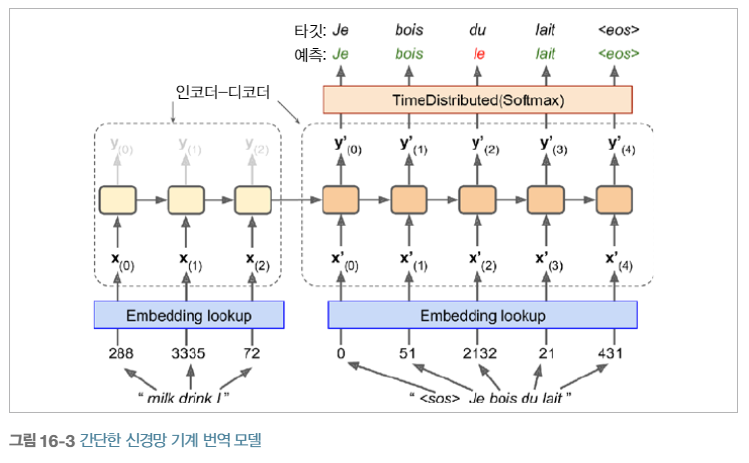

In [45]:
vocab_size = 100
embed_size = 10

In [ ]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

### 16.3.1 양방향 RNN

일반적인 순환 층은 과거와 현재의 입력만 보고 출력을 생성 <BR>
→ 시계열을 예측할 때 적합하지만 여러 종류의 자연어 처리 작업에는 적절하지 않을 수 있음 <br>

예시) the Queen of United Kingdom / the queen of hears / the queen bee <br>
→ queen을 올바르게 인코딩 하려면 구 단어를 알아야 함 <br>

해결) 양방향 순환층 : 동일한 입력에 대해 왼 > 오, 오 > 왼 2개의 순환층 실행 <br>
→ keras.layers.Bidirectional() 사용 <br>

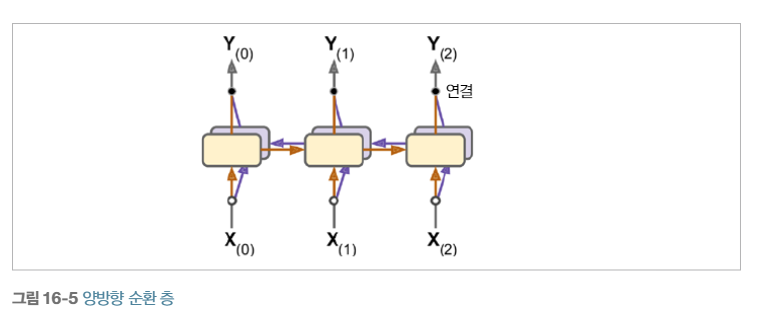

In [48]:
# Bidirectional 층은 GRU 층을 반대 방향으로 복사하고 두 층을 실행하여 출력을 연결 함

model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, None, 10)          660       
                                                                 
 bidirectional (Bidirectiona  (None, None, 20)         1320      
 l)                                                              
                                                                 
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### 16.3.2 빔 검색

스텝마다 무조건 가장 가능성 있는 단어를 출력해서는 최적의 번역을 만들 수 없음 <br>
→ 모델이 앞선 실수를 고칠 수 있게 하는 방법 : 빔 검색

* 빔 검색 <br>
k개의 가능성 있는 문장의 리스트를 유지하고 디코더 단계마다 이 문장의 단어를 하나씩 생성하여 가능성 있는 k개의 문장을 만듦 (k = 빔 너비)

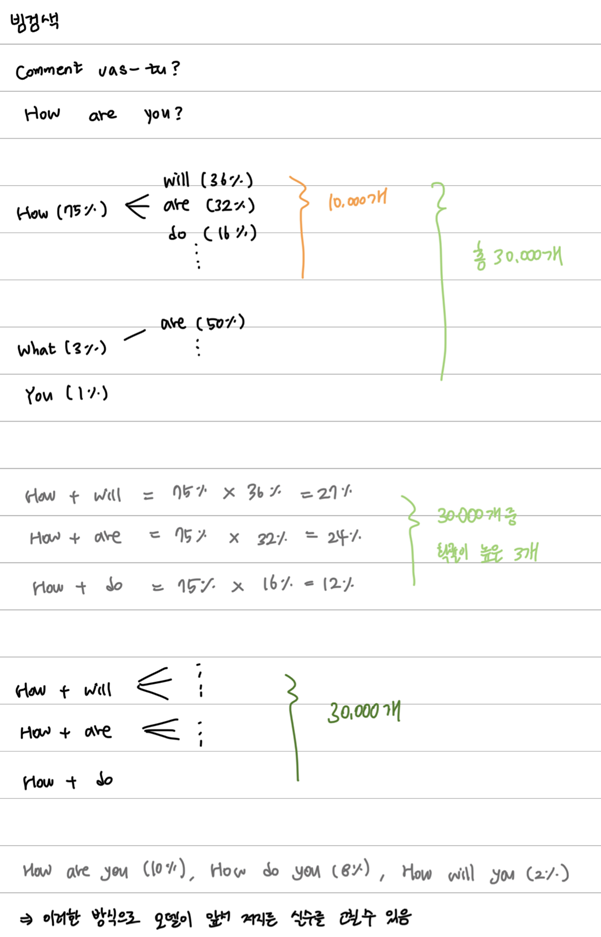

In [ ]:
# 디코더 셀을 감싼 BeamSearchDecoder를 만듦
# 각 디코더를 위해 인코더의 마지막 상태 복사

beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder( 
    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer)
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch( 
    encoder_state, multiplier=beam_width)
utputs, _, _ = decoder( 
    embedding_decoder, start_tokens=start_tokens, end_token=end_token, 
    initial_state=decoder_initial_state)

장점) 짧은 문장에 대해서 좋은 번역 가능 <br>
단점) 긴 문장에서 나쁜 성능 (RNN의 제한된 단기 기억으로 인한 문제) -> 어텐션 메커니즘으로 해결

## 16.4 어텐션 메커니즘

각 타임 스텝에서 적절한 단어에 디코더가 초점을 맞추는 기술을 통해 입력 단어에서 번역까지 경로가 짧아지도록 만듦 <br>
→ RNN의 단기 기억 제한성에 영향이 적어짐

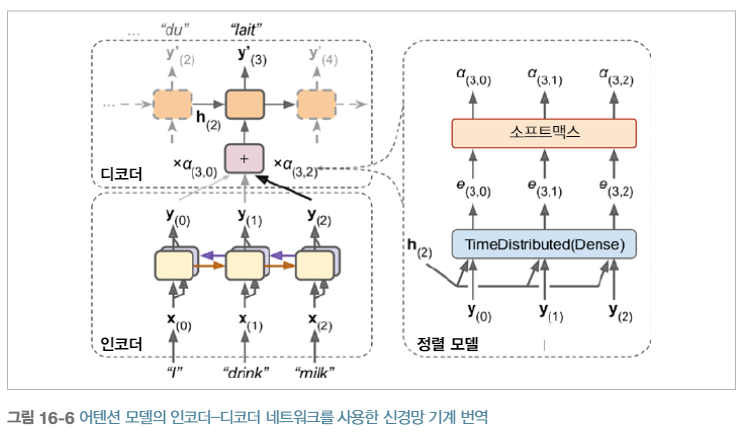

인코더의 마지막 입력 상태 + **은닉 상태**가 디코더에 전송됨 <br>
디코더에 메모리 셀은 모든 인코더 출력의 가중치 합을 계산하여 **집중할 단어를 결정** <br>

* α(t, i) : t번째 디코더 타임 스텝에서 i번째 인코더 출력의 가중치 <br>
→ α(3, 2) > α(3, 1) 인 경우 3번째 타임 스텝에서 디코더는 2번째 단어에 더 많은 주의를 기울임<br>

* 정렬 모델 : 가중치 생성되는 곳 <br>
→ Dense 층 : 하나의 뉴런으로 구성되어 인코더의 모든 출력을 입려ㄱ으로 받아 디코더의 이전 은닉상태 결정 / 각 인코더 출력에 대한 점수 출력 (e : 각 출력이 디코더의 은닉 상태와 얼마나 잘 맞는지 측정) <br>
→ Softmax 층 : 인코더 출력에 대한 최종 가중치를 얻음 (타임 스텝에 대한 
모든 가중치 합은 1)

**=> 바흐다나우 어텐션, 연결 어텐션 (인코더의 출력과 디코더의 이전 은닉 상태 연결)**

### 16.4.1 비주얼 어텐션

* 비주얼 어텐션을 사용한 이미지 캡션 생성 <br>
1. 합성곱 신경망이 먼저 이미지를 처리하여 일련의 특성 맵을 출력 
2. 어텐션 메커니즘을 장착한 디코더 RNN이 한 번에 한 단어씩 캡션을 생성 <br>
(디코더가 어텐션 모델을 사용해 이미지에서 적절한 부위에 초점을 맞춤)

예시) 아래의 그림에 대해 - A woman is throwing a frisbee in a park


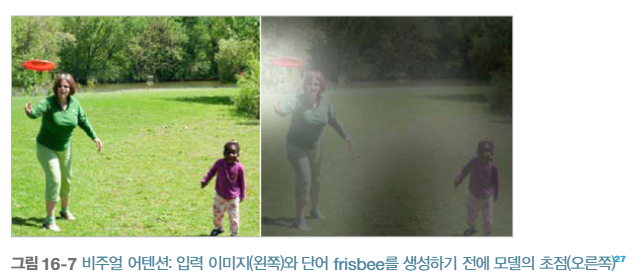

### 16.4.2 트랜스포머 구조: 어텐션이 필요한 전부다 

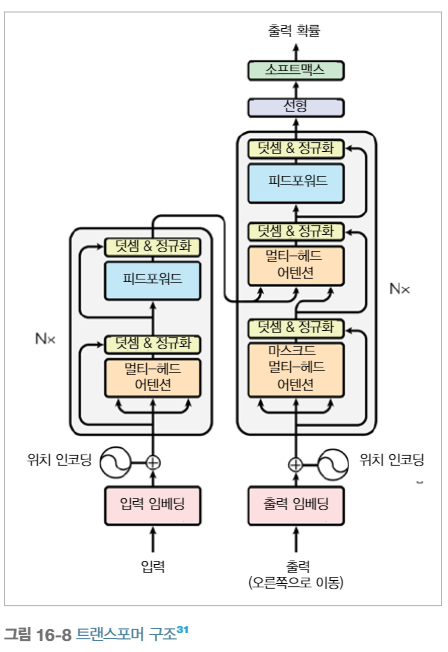

* 위치 인코딩 <br>
문장 안에 단어의 위치를 인코딩한 밀집 벡터 <br>
i번째 위치 인코딩이 문장에 있는 i번째 단어의 단어 임베딩에 더해짐 <br>
<br>
모델을 사용해 위치 인코딩을 학습할 수 있지만 논문 저자들은 사인, 코사인 함수로 정의한 고정 인코딩 선호 <br>
→ 동일한 성능으로 임의의 긴 문장으로 확장 가능 / 진동 함수 선택에 따라 모델이 상대적인 위치도 학습 가능

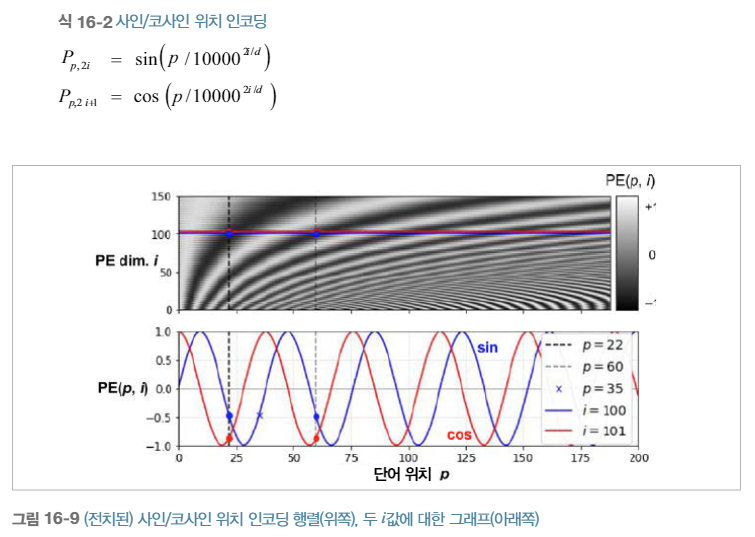

In [50]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [51]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

* 스케일드 점-곱 어텐션 <br>
예시) 문장을 분석하기
입력 문장 : They played chess<br>
인코더가 {주어: They, 동사: played ...}등과 같은 딕셔너리를 만들고 디코더가 키 값을 찾는 과정 <br>
→ 모델은 벡터 표현으로 키를 표현하기에 룩업에 사용할 키(쿼리)가 딕셔너리 키와 완벽하게 매칭되지 않음 <br>

* 해결방법
1. 쿼리와 키(동사) 사이의 유사도를 계산 
2. 소프트맥스 함수를 사용해 유사도 점수를 합해서 1이 되는 가중치로 바꿈 
3. 모델이 키에 해당하는 값의 가중치 합을 계산
4. 키(동사) 가중치가 1에 가까우면 가중치 합이 played 표현과 가까워짐

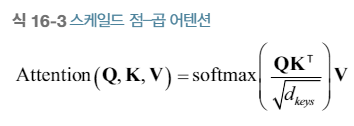

* 멀티 헤드 어텐션 <br>
스케일드 점-곱 어텐션 층의 묶음

* 탄생 배경 <br>
인코더가 played의 많은 특징(동사, 위치 등)을 인코딩 했다고 가정 <br>
→ 하나의 스케일드 점-곱 어텐션 층만 사용한다면 한번에 이런 특징을 모두 쿼리할 수 없음 <br>
멀티-헤드 어텐션 층이 값, 키, 쿼리의 여러가지 선형 변환을 적용하여 모델이 단어 표현을 여러 부분 공간으로 투영함 <br>
(각 부분 공간은 단어의 일부 특징에 주목 : 선형 층1 - 동사, 선형 층2 - 위치)<br>
스케일드 점-곱 어텐션 층이 룩업 단계를 구현하고 마지막으로 모든 결과를 원본 공간으로 다시 투영



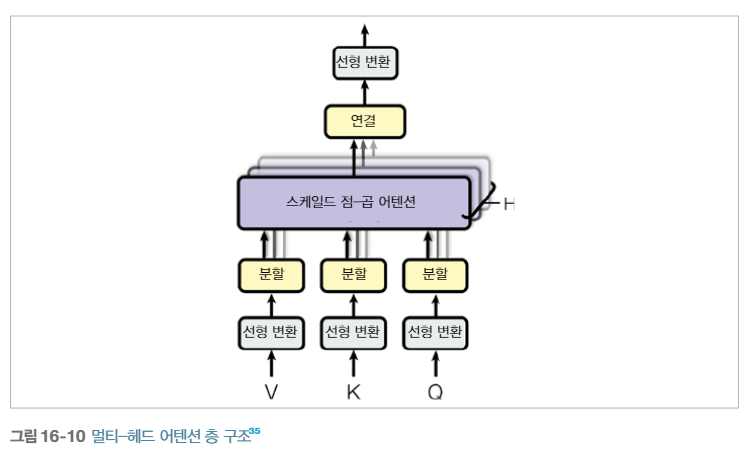